<a href="https://colab.research.google.com/github/mcarhuasn/DIA2022-VisionArtif-ClasificacionCOVID/blob/master/Proyecto_Clasificacion_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h1><font color="#113D68" size=5.5>Proyecto: Clasificación de Pacientes con COVID-9 usando imágenes de Rayos X</font></h1>**

<h1><font color="#113D68" size=5>Curso: Desarrollo de Aplicaciones con Visión Artificial</font></h1>

<h1><font color="#113D68" size=4>Docentes: Dr. Analí Alfaro Alfaro, Mg. Alaín Alejo Huarachi</font></h1>

<h1><font color="#113D68" size=4>Grupo:

- Milton Carhuas Ñañez

- Carlos Incasoller Vilca

</font></h1>

<a id="section23"></a>
## <font color="#004D7F"> Importación de Librerías</font>

In [60]:
# importando librerías
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
#import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from PIL import Image
import cv2
import plotly.express as px
import plotly.subplots as subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score, roc_curve, auc, plot_roc_curve
from sklearn.utils.multiclass import unique_labels
import math
import time
import copy
import os, sys, shutil, time, datetime, random
%matplotlib inline

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. RECUPERACIÓN DE INFORMACIÓN</font>

#### Creación de variables globales para directorios y archivos

In [2]:
# Directorios
DIR_PROY = '/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA'
DIR_REPOS_PROY = DIR_PROY + '/covid-chestxray-dataset'
DIR_METADATA = DIR_REPOS_PROY + '/'
DIR_DATA = DIR_REPOS_PROY + '/images'
DIR_COVID = DIR_DATA + "/covid"
DIR_NO_COVID = DIR_DATA + "/no-covid"
DIR_MODELOS = DIR_PROY + '/modelos'

# Archivos
FILE_METADATA = 'metadata.csv'

#### Habilitar acceso a directorios de Google Drive

In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [4]:
!pwd

/content


In [5]:
!ls -ltrh /content/

total 8.0K
drwxr-xr-x 1 root root 4.0K Jun 29 13:44 sample_data
drwx------ 6 root root 4.0K Jul  3 03:02 drive


In [6]:
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/"

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA


In [7]:
# Nota Importante:
# Este bloque de celda se ejecuta una sola vez

# Debe ser ejecutado una sola vez para copiar el repositorio GitHub en Google Drive en el directorio Proyecto_VA
#! git clone https://github.com/ieee8023/covid-chestxray-dataset

In [8]:
# Tamaño del directorio de imagenes
!du -h "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images"

289M	/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/covid
238M	/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/no-covid
526M	/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images


In [9]:
# Cantidad de elementos del directorio de imagenes
!ls "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images" | wc -l

2


In [10]:
# Tipos de archivo del directorio de imagenes
!find "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images" -type f | awk -F. '!a[$NF]++{print $NF}'

jpg
jpeg
png
PNG
JPG


#### Importación de Metadata (Etiqueta por cada Imagen)

In [11]:
df_metadata = pd.read_csv(DIR_METADATA + FILE_METADATA, sep=',')
print('Tamaño del conjunto de datos: ', df_metadata.shape)
df_metadata.head(5)

Tamaño del conjunto de datos:  (950, 30)


patientid  offset sex   age                   finding RT_PCR_positive  \
0         2     0.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
1         2     3.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
2         2     5.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
3         2     6.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
4         4     0.0   F  52.0  Pneumonia/Viral/COVID-19               Y   

  survival intubated intubation_present went_icu  ...              date  \
0        Y         N                  N        N  ...  January 22, 2020   
1        Y         N                  N        N  ...  January 25, 2020   
2        Y         N                  N        N  ...  January 27, 2020   
3        Y         N                  N        N  ...  January 28, 2020   
4      NaN         N                  N        N  ...  January 25, 2020   

                                            location  folder  \
0        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
1        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
2        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
3        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
4  Changhua Christian Hospital, Changhua City, Ta...  images   

                                            filename                   doi  \
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
1  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
2  auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
3  auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
4                              nejmc2001573_f1a.jpeg  10.1056/NEJMc2001573   

                                                 url  license  \
0  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
1  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
2  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
3  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
4  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   

                                      clinical_notes other_notes Unnamed: 29  
0  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
1  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
2  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
3  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
4   diffuse infiltrates in the bilateral lower lungs         NaN         NaN  

[5 rows x 30 columns]

In [12]:
# Cantidad de imágenes para enfermedad del tipo COVID-9
df_metadata[df_metadata["finding"]=='Pneumonia/Viral/COVID-19'].shape

(584, 30)

In [13]:
# Cantidad de imágenes por tipo de enfermedad
pd.DataFrame(df_metadata["finding"].value_counts(dropna=False))

finding
Pneumonia/Viral/COVID-19                     584
todo                                          83
Pneumonia                                     81
Pneumonia/Fungal/Pneumocystis                 30
Pneumonia/Bacterial/Streptococcus             22
No Finding                                    22
Tuberculosis                                  18
Pneumonia/Viral/SARS                          16
Pneumonia/Lipoid                              13
Pneumonia/Bacterial/Mycoplasma                11
Pneumonia/Viral/MERS-CoV                      10
Pneumonia/Bacterial/Klebsiella                10
Pneumonia/Bacterial/Legionella                10
Pneumonia/Bacterial/Nocardia                   8
Pneumonia/Viral/Varicella                      6
Pneumonia/Viral/Influenza                      5
Pneumonia/Bacterial                            4
Pneumonia/Bacterial/E.Coli                     4
Pneumonia/Viral/Herpes                         3
Pneumonia/Bacterial/Chlamydophila              3
Pneumonia/Viral/Influenza/H1N1                 2
Pneumonia/Fungal/Aspergillosis                 2
Unknown                                        1
Pneumonia/Aspiration                           1
Pneumonia/Bacterial/Staphylococcus/MRSA        1

In [14]:
# Cantidad de imágenes por tipo de carpeta
pd.DataFrame(df_metadata["folder"].value_counts(dropna=False))

folder
images      929
volumes      21

#### Creación de Variable Objetivo

In [15]:
df_metadata['label'] = [1 if x == 'Pneumonia/Viral/COVID-19' else 0 for x in df_metadata['finding']]
print(df_metadata.shape)
df_metadata[['finding','folder','filename','label']].head(5)

(950, 31)


finding  folder  \
0  Pneumonia/Viral/COVID-19  images   
1  Pneumonia/Viral/COVID-19  images   
2  Pneumonia/Viral/COVID-19  images   
3  Pneumonia/Viral/COVID-19  images   
4  Pneumonia/Viral/COVID-19  images   

                                            filename  label  
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...      1  
1  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...      1  
2  auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...      1  
3  auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...      1  
4                              nejmc2001573_f1a.jpeg      1

#### Definición de Universo

In [16]:
pd.set_option('display.max_colwidth',-1)

df_metadata_u = df_metadata.copy()
df_metadata_u = df_metadata_u[['finding','folder','filename','label']][df_metadata["folder"]=='images']
print('Tamaño del conjunto de datos: ', df_metadata_u.shape)
df_metadata_u.head(5)

Tamaño del conjunto de datos:  (929, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


finding  folder  \
0  Pneumonia/Viral/COVID-19  images   
1  Pneumonia/Viral/COVID-19  images   
2  Pneumonia/Viral/COVID-19  images   
3  Pneumonia/Viral/COVID-19  images   
4  Pneumonia/Viral/COVID-19  images   

                                                                 filename  \
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg   
1  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg   
2  auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg   
3  auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg   
4  nejmc2001573_f1a.jpeg                                                    

   label  
0  1      
1  1      
2  1      
3  1      
4  1

In [17]:
# Cantidad de imágenes por tipo de enfermedad para Universo
pd.DataFrame(df_metadata_u["finding"].value_counts(dropna=False))

finding
Pneumonia/Viral/COVID-19                 563    
todo                                     83     
Pneumonia                                81     
Pneumonia/Fungal/Pneumocystis            30     
Pneumonia/Bacterial/Streptococcus        22     
No Finding                               22     
Tuberculosis                             18     
Pneumonia/Viral/SARS                     16     
Pneumonia/Lipoid                         13     
Pneumonia/Bacterial/Mycoplasma           11     
Pneumonia/Viral/MERS-CoV                 10     
Pneumonia/Bacterial/Klebsiella           10     
Pneumonia/Bacterial/Legionella           10     
Pneumonia/Bacterial/Nocardia             8      
Pneumonia/Viral/Varicella                6      
Pneumonia/Viral/Influenza                5      
Pneumonia/Bacterial                      4      
Pneumonia/Bacterial/E.Coli               4      
Pneumonia/Viral/Herpes                   3      
Pneumonia/Bacterial/Chlamydophila        3      
Pneumonia/Viral/Influenza/H1N1           2      
Pneumonia/Fungal/Aspergillosis           2      
Unknown                                  1      
Pneumonia/Aspiration                     1      
Pneumonia/Bacterial/Staphylococcus/MRSA  1

#### Clasificación de imágenes por clase (COVID / NO-COVID)

In [18]:
# Nota Importante:
# Este bloque de celda se ejecuta una sola vez


# # DIR_COVID = DIR_DATA + "covid/"
# # DIR_NO_COVID = DIR_DATA + "no-covid/"

# Creacion de carpetas para cada clase de la variable objetivo
# os.mkdir(DIR_COVID)
# print("Directory '% s' created" % DIR_COVID)

# os.mkdir(DIR_NO_COVID)
# print("Directory '% s' created" % DIR_NO_COVID)

In [19]:
# Nota Importante:
# Este bloque de celda se ejecuta una sola vez

# Trasladar imagenes de carpeta raiz de imagenes a la carpeta de la clase correspondiente
# segun etiqueta de variable objetivo definida en archivo metadata.csv

# count = 0

# for path, dirs, files in os.walk(DIR_DATA):
#   for filename in files:
#     #print(os.path.join(filename))
#     #print(filename)
#     dir_orig = os.path.join(DIR_DATA, filename)

#     for idx, row in df_metadata_u.iterrows():
#       if row['filename'] == filename and row['label'] == 1:
#         count = count + 1
#         #print('Indice DF: ', idx, ' | Imagen COVID: ', row['filename'], ' $ ' , filename, ' | Contador: ', count)

#         shutil.move(dir_orig, DIR_COVID)
#       elif row['filename'] == filename and row['label'] != 1:
#         shutil.move(dir_orig, DIR_NO_COVID)

# print('Cantidad de imagenes COVID movidas a nueva carpeta: ', count)

In [20]:
# Cantidad de archivos en carpeta "covid"
!ls "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/covid" | wc -l

563


In [21]:
# Cantidad de archivos en carpeta "covid"
!ls "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/no-covid" | wc -l

366


In [138]:
image = cv2.imread('/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/covid/0a6c60063b4bae4de001caaba306d1_jumbo.jpeg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_rgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

In [140]:
image_rgb.shape

(995, 1024, 3)

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 1. COMPRENSIÓN DEL NEGOCIO</font>

Colección de dataset de imágenes de COVID-9:

https://github.com/ieee8023/covid-chestxray-dataset

---
<a id="section0"></a>
# <font color="#004D7F" size=6>2. COMPRENSIÓN DE LOS DATOS</font>

<a id="section23"></a>
## <font color="#004D7F"> 2.1. Importación de Datos</font>

In [49]:
IMG_RESIZE = 255
IMG_SIZE = 224
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

In [23]:
# make some augmentations on training data
transform_da = transforms.Compose([
                                   #transforms.RandomResizedCrop((IMG_RESIZE, IMG_RESIZE)),
                                   transforms.Resize(IMG_RESIZE), # Resize the image to 255×255 pixels.
                                   transforms.CenterCrop(IMG_SIZE), # Crop the image to 224×224 pixels about the center.
                                   transforms.ToTensor(), # Convert the image to PyTorch Tensor data type.
                                   transforms.Normalize(IMG_MEAN, IMG_STD)] # Normalize the image by setting its mean and standard deviation to the specified values.
                                  )

In [56]:
# Definiendo el dataset
# dataset = datasets.ImageFolder(DIR_DATA,
#                               transform=transforms.Compose([
#                                   #transforms.RandomResizedCrop(224),
#                                   transforms.Resize(255), # Resize the image to 255×255 pixels.
#                                   transforms.CenterCrop(224), # Crop the image to 224×224 pixels about the center.
#                                   transforms.ToTensor(), # Convert the image to PyTorch Tensor data type.
#                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
#                                                        std=[0.229, 0.224, 0.225]
#                                                        ) # Normalize the image by setting its mean and standard deviation to the specified values.
#                                   ]))

dataset = datasets.ImageFolder(DIR_DATA,
                              transform=transform_da)

CLASS_NAMES = dataset.classes

print('Tamaño del conjunto de datos total: ', len(dataset))
print('Clases de la variable objetivo: ', CLASS_NAMES)

Tamaño del conjunto de datos total:  929
Clases de la variable objetivo:  ['covid', 'no-covid']


In [25]:
# Imagen de Muestra
dataset[0][0]

tensor([[[0.7591, 0.7591, 0.7933,  ..., 0.4679, 0.4679, 0.4508],
         [0.7591, 0.7762, 0.7933,  ..., 0.5536, 0.5193, 0.4508],
         [0.7933, 0.8447, 0.8104,  ..., 0.6392, 0.5364, 0.5022],
         ...,
         [0.4851, 0.4337, 0.4679,  ..., 0.6734, 0.6049, 0.5878],
         [0.5022, 0.4851, 0.5022,  ..., 0.6563, 0.5707, 0.5878],
         [0.5193, 0.5193, 0.4851,  ..., 0.6392, 0.6392, 0.6563]],

        [[0.9055, 0.9055, 0.9405,  ..., 0.6078, 0.6078, 0.5903],
         [0.9055, 0.9230, 0.9405,  ..., 0.6954, 0.6604, 0.5903],
         [0.9405, 0.9930, 0.9580,  ..., 0.7829, 0.6779, 0.6429],
         ...,
         [0.6254, 0.5728, 0.6078,  ..., 0.8179, 0.7479, 0.7304],
         [0.6429, 0.6254, 0.6429,  ..., 0.8004, 0.7129, 0.7304],
         [0.6604, 0.6604, 0.6254,  ..., 0.7829, 0.7829, 0.8004]],

        [[1.1237, 1.1237, 1.1585,  ..., 0.8274, 0.8274, 0.8099],
         [1.1237, 1.1411, 1.1585,  ..., 0.9145, 0.8797, 0.8099],
         [1.1585, 1.2108, 1.1759,  ..., 1.0017, 0.8971, 0.

In [26]:
print('Tipo de datos del 1er elemento del dataset: ', type(dataset[0])) # tupla(0 => tensor, 1 => label)
print('Tamaño del 1er elemento del dataset: ', len(dataset[0])) # tupla(0 => tensor, 1 => label)

# Dimensiones para una imagen de muestra (indice = 0)
print('Dimension de la imagen del 1er elemento: ', dataset[0][0].shape) # dimension del tensor
print(f'Label del 1er elemento = {dataset[0][1]}') # label

Tipo de datos del 1er elemento del dataset:  <class 'tuple'>
Tamaño del 1er elemento del dataset:  2
Dimension de la imagen del 1er elemento:  torch.Size([3, 224, 224])
Label del 1er elemento = 0


<a id="section23"></a>
## <font color="#004D7F"> 2.3. Análisis Exploratorio de Datos</font>

In [27]:
# Mostramos algunos ejemplos
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  fig = px.imshow(inp, title=title)
  fig.update_layout(title_x=.5)
  fig.show()

Numero de batch: 0
Tamaño del batch de imagenes: torch.Size([4, 3, 224, 224])
Tamaño del batch de targets : torch.Size([4])



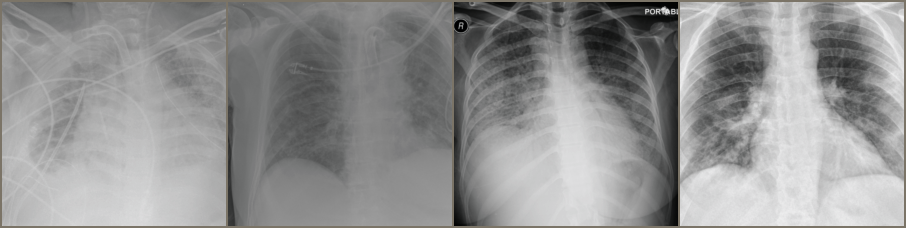

In [28]:
dataset_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Crear un iterador sobre la lista de batches
examples = enumerate(dataset_loader)

 # Obtener el siguiente batch del iterador
batchId, (exampleData_inputs, exampleTargets_classes) = next(examples)
print(f'Numero de batch: {batchId}')
print(f'Tamaño del batch de imagenes: {exampleData_inputs.shape}')
print(f'Tamaño del batch de targets : {exampleTargets_classes.shape}')

#inputs, classes = next(iter(dataset_loader))
exampleData_inputs, exampleTargets_classes = next(iter(dataset_loader))
#out = torchvision.utils.make_grid(inputs)
out = torchvision.utils.make_grid(exampleData_inputs)

imshow(out, title=', '.join(str(class_names[x]) for x in exampleTargets_classes))

In [29]:
# Mostramos los primeros 16 elementos del batch con su etiqueta
fig = subplots.make_subplots(1, 4, subplot_titles=[f'Groundtruth: {exampleTargets_classes[i]}' for i in range(4)])

for i in range(4):
  row = i//4 + 1
  col = i%4 + 1
  fig.add_trace(px.imshow(exampleData_inputs[i][0]).data[0], row, col)

fig.update_yaxes(autorange='reversed')
fig.update_xaxes(scaleanchor='y',scaleratio=1)
fig.update_layout(coloraxis=dict(colorscale='gray_r'))
fig.show()

---
<a id="section0"></a>
# <font color="#004D7F" size=6>3. PREPARACIÓN DE LOS DATOS</font>

#### Creación de variables globales para hiperparámetros para preparación de los datos

In [30]:
# Hiperparámetros
PROPORC_TEST = 0.20
PROPORC_VALID = 0.25
#INPUT_SIZE = 150528 # 3x224x224
BATCH_SIZE_TRAIN = 4 # tamaño de batch para el train (tamaño de c/ particion del train) (Se recomienda que sea minimo, aunque depende del problema)
BATCH_SIZE_VALID = 4 # tamaño de batch para el valid (tamaño de c/ particion del valid) (Se recomienda que sea minimo, aunque depende del problema)
BATCH_SIZE_TEST = 10 # tamaño de batch para el test (tamaño de c/ particion del test)

<a id="section23"></a>
## <font color="#004D7F"> 3.1. División de los Datos</font>

In [31]:
# Definir tamaño de división de subconjunto de entrenamiento y prueba
n_test = int(len(dataset) * PROPORC_TEST)
n_trainvalid = len(dataset) - n_test

n_valid = int(n_trainvalid * PROPORC_VALID)
n_train = n_trainvalid - n_valid

# Particionar en forma aleatoria en subconjuntos de entrenamiento y prueba
trainvalid_dataset, test_dataset = random_split(dataset, [n_trainvalid, n_test])

train_dataset, valid_dataset = random_split(trainvalid_dataset, [n_train, n_valid])

#print(f'n_train = {len(train_dataset)}')
print(f'n_train = {n_train}')
#print(f'n_valid = {len(valid_dataset)}')
print(f'n_valid = {n_valid}')
#print(f'n_test = {len(test_dataset)}')
print(f'n_test = {n_test}')

n_train = 558
n_valid = 186
n_test = 185


In [35]:
print(type(dataset))
print(type(dataset.imgs))
print(type(test_dataset))
dataset.imgs[0]

<class 'torchvision.datasets.folder.ImageFolder'>
<class 'list'>
<class 'torch.utils.data.dataset.Subset'>


('/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/covid/00870a9c.jpg',
 0)

In [36]:
# Particionamos los subconjuntos en minibatches
train_loader = DataLoader(train_dataset, # conjunto de datos de train
                          batch_size=BATCH_SIZE_TRAIN, # tamaño del batch para train
                          shuffle=True # reordenar la data en cada epoca de entrenamiento (para evitar overfitting)
                          )

valid_loader = DataLoader(valid_dataset, # conjunto de datos de train
                          batch_size=BATCH_SIZE_VALID, # tamaño del batch para valid
                          shuffle=True # reordenar la data en cada epoca de entrenamiento (para evitar overfitting)
                          )

test_loader = DataLoader(test_dataset, # conjunto de datos de test
                         batch_size=BATCH_SIZE_TEST, # tamaño del batch para test
                         shuffle=False # sin reordanmiento por epoca (debido a que se hara un solo recorrido o iteracion y ya no se hace calculo del gradiente, es decir, no se requiere mucho procesamiento)
                         )

In [37]:
print('Nro de batchs de train: ', len(train_loader)) # nro de batches
print('Nro de batchs de train (cálculo manual): ', math.ceil(len(train_dataset)/BATCH_SIZE_TRAIN))

print('Nro de batchs de train: ', len(valid_loader)) # nro de batches
print('Nro de batchs de train (cálculo manual): ', math.ceil(len(valid_dataset)/BATCH_SIZE_VALID))

print('Nro de batchs de train: ', len(test_loader)) # nro de batches
print('Nro de batchs de train (cálculo manual): ', math.ceil(len(test_dataset)/BATCH_SIZE_TEST))

Nro de batchs de train:  140
Nro de batchs de train (cálculo manual):  140
Nro de batchs de train:  47
Nro de batchs de train (cálculo manual):  47
Nro de batchs de train:  19
Nro de batchs de train (cálculo manual):  19


In [38]:
# Tamaño del conjunto de datos de entrenamiento (formas equivalentes de obtener el tamaño)
len(train_loader.dataset), len(train_dataset)

(558, 558)

<a id="section0"></a>
# <font color="#004D7F" size=6>4. MODELADO DE LOS DATOS</font>

#### Creación de variables globales para hiperparámetros para modelado de los datos

In [39]:
NUM_EPOCHS = 25
NUM_CLASSES = 2
MOMENTUM = 0.9
LOG_INTERVAL = 100
LEARNING_RATE = 0.001

In [40]:
# Habilitar tarjeta grafica GPU
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
# Función de entrenamiento y validación
def train_model(device, model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  list_epochs = []
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []

  rs = '------------------------------------------------------------------'
  print('Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best')
  print(rs)
  
  # Por cada época (iteración)
  for epoch in range(num_epochs):
    
    # Modelo en modo: train (Entrenamiento)
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    # Por cada batch del conjunto de datos
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      # Obtener la probabilidad de predicción
      outputs = model(inputs)

      # Obtener la clase de predicción en base a la predicción (convertir la probabilidad en la clase)
      _, preds = torch.max(outputs, 1)

      # Calcular el error (la función de pérdida)
      loss = criterion(outputs, labels)
      
      # Propagating the error backward
      loss.backward()

      # Take a step with the optimizer to update the model parameters.
      optimizer.step()

      # Clear the gradients of all optimized variables.
      optimizer.zero_grad()
      
      # Actualizar error
      running_loss += loss.item() * inputs.size(0)

      # Acumular cantidad de aciertos (verdaderos positivos y negativos)
      running_corrects += torch.sum(preds == labels.data)
    
    result = {}
    
    # Calcular Error Promedio (suma de errores / cantidad total de elementos)
    result['train_loss'] = running_loss / len(train_loader.dataset) # n_train <> len(train_loader.dataset)

    # Calcular Accuracy (cantidad de aciertos / cantidad total de elementos)
    result['train_acc'] = (running_corrects.double() / len(train_loader.dataset)).cpu().detach().numpy() # n_train <> len(train_loader.dataset)
    train_losses.append(result['train_loss'])
    train_accs.append(result['train_acc'])

    scheduler.step()
    
    # Modelo en modo: valid (Validación)
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in valid_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    result['val_loss'] = running_loss / len(valid_loader.dataset) # n_valid <> len(valid_loader.dataset)
    result['val_acc'] = (running_corrects.double() / len(valid_loader.dataset)).cpu().detach().numpy() # n_valid <> len(valid_loader.dataset)
    epoch_acc = result['val_acc']

    valid_losses.append(result['val_loss'])
    valid_accs.append(result['val_acc'])

    st = '          '
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      st = '   ***    '
        
    print("%5d %11.4f %11.4f %11.4f %11.4f %s" % (epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'], st))

    list_epochs.append(epoch+1)

  print(rs)
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best Val accuracy: {best_acc:.4f}')

  model.load_state_dict(best_model_wts)

  return model, result, list_epochs, train_losses, train_accs, valid_losses, valid_accs

# Función para pruebas
def test(device, model, test_loader, criterion):
  since = time.time()

  # Modelo en modo: valid (Validación)
  model.eval()
  test_loss = 0.0
  test_corrects = 0.0
  test_losses = []
  test_accs = []
  test_probs = []
  test_preds = []
  test_targets = []
  
  rs = '------------------------------------------------------------------'
  print('BatchId    Cant. Imagenes')
  print(rs)

  with torch.no_grad():
    #for images, labels in test_loader:
    for batch_idx, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
        outputs = model(images)
        #pred = outputs.data.max(1, keepdim=True)[1]
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        probs = F.softmax(outputs, dim=1) # clasificacion: multiclase (general, tambien sirve para binaria)
        # probs = torch.sigmoid(output)[0] # clasificacion: binaria 

      #test_loss += criterion(outputs, labels, reduction='sum').item()        
      test_loss += loss.item() * images.size(0)

      #test_corrects += preds.eq(labels.data.view_as(preds)).sum()
      test_corrects += torch.sum(preds == labels.data)

      #test_losses.append(test_loss)
      #test_accs.append(test_corrects)
      test_targets.append(labels)
      test_probs.append(probs)
      test_preds.append(preds)
  
      print(batch_idx+1, '         ', len(images))

  test_loss_avg = test_loss / len(test_loader.dataset) # n_test <> len(test_loader.dataset)
  test_acc_avg = (test_corrects.double() / len(test_loader.dataset)).cpu().detach().numpy() # n_tes <> len(test_loader.dataset)

  print(rs)
  time_elapsed = time.time() - since
  print(f'Prediction complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'\nTest Avg. Loss: {test_loss_avg:.4f}')
  print(f'Test Accuracy: {test_acc_avg:.4f}')

  return test_probs, test_preds, test_targets

def transformar_imagen(img_filename, img_resize, img_size, img_mean, img_std):
  '''
  Pre procesamiento de la imagen
  '''
  transf = transforms.Compose([
                               #transforms.RandomResizedCrop((img_size, img_size)),
                               transforms.Resize(img_resize), # Resize the image to 255×255 pixels.
                               transforms.CenterCrop(img_size), # Crop the image to 224×224 pixels about the center.
                               transforms.ToTensor(), # Convert the image to PyTorch Tensor data type.
                               transforms.Normalize(img_mean, img_std)] # Normalize the image by setting its mean and standard deviation to the specified values.
                              )

  image = Image.open(img_filename)
  # Tamaño (3,224,224) => (1, 3, 224, 224)

  return transf(image).unsqueeze(0) # tensor singleton


def prediccion2(device, model, img_filename, img_resize, img_size, img_mean, img_std):
  '''
  Predicción con grado de confidencia
  '''
  tensor = transformar_imagen(img_filename, img_resize, img_size, img_mean, img_std)
  model.eval()
  pred = model(tensor) # prediccion de clase
  output = F.softmax(pred, dim=-1) # prediccion de probabilidad
  conf, val = output.max(1)
  index = str(val.item())

  return output.detach().numpy(), dict({'conf':conf})

# # Definimos algunas funciones
# def predict_img(device,
#                 model,
#                 full_img,
#                 scale_factor=1,
#                 out_threshold=0.5):
#     ''' transformando imagen '''
#     model.eval()

#     img = torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor, is_mask=False))
#     img = img.unsqueeze(0)
#     img = img.to(device=device, dtype=torch.float32)

#     with torch.no_grad():
#         output = model(img)

#         if model.n_classes > 1:
#             probs = F.softmax(output, dim=1)[0]
#         else:
#             probs = torch.sigmoid(output)[0]

#         # tf = transforms.Compose([
#         #     transforms.ToPILImage(),
#         #     transforms.Resize((full_img.size[1], full_img.size[0])),
#         #     transforms.ToTensor()
#         # ])

#         transf = transforms.Compose([#transforms.RandomResizedCrop((img_size, img_size)),
#                                     transforms.Resize(img_resize), # Resize the image to 255×255 pixels.
#                                     transforms.CenterCrop(img_size), # Crop the image to 224×224 pixels about the center.
#                                     transforms.ToTensor(), # Convert the image to PyTorch Tensor data type.
#                                     transforms.Normalize(img_mean, img_std)] # Normalize the image by setting its mean and standard deviation to the specified values.
#                                     ) 

#         image = Image.open(full_img)
#         transf(image).unsqueeze(0) # tensor singleton

#         full_mask = transf(probs.cpu()).squeeze()

#     if model.n_classes == 1:
#         return (full_mask > out_threshold).numpy()
#     else:
#         return F.one_hot(full_mask.argmax(dim=0), net.n_classes).permute(2, 0, 1).numpy()


# Mostramos las predicciones
def visualize_model(model, test_loader, class_names, num_images = 8):
  was_training = model.training
  model.eval()
  images_so_far = 0
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      
      for j in range(inputs.size()[0]):
        images_so_far += 1
        imshow(inputs.cpu().data[j], f'predicted: {class_names[preds[j]]}')
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de Confusión Normalizada'
        else:
            title = 'Matriz de Confusión sin Normalizar'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión Normalizada")
    else:
        print('Matriz de Confusión sin Normalizar')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(linewidth=.0)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    plt.show()
    return ax    

<a id="section23"></a>
## <font color="#004D7F"> 4.1. Modelo de Línea Base</font>

<a id="section23"></a>
## <font color="#004D7F"> 4.2. Transfer Learning con ResNet18</font>

In [ ]:
# Definimos el modelo
modelo_tf_resnet18 = models.resnet18(pretrained=True)
print(modelo_tf_resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# "Congelar" los pesos del modelo pre-entrenado
for param in modelo_tf_resnet18.parameters():
  param.requires_grad = False

# Modificamos la última capa para clasificación binaria (del problema)
modelo_tf_resnet18.fc = nn.Linear(in_features=512, out_features=NUM_CLASSES)
modelo_tf_resnet18 = modelo_tf_resnet18.to(device)

In [ ]:
# Creacion de optimizador SGD
optimizer_tf_resnet18 = torch.optim.SGD(modelo_tf_resnet18.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Creacion de Scheduler
scheduler_tf_resnet18 = torch.optim.lr_scheduler.StepLR(optimizer_tf_resnet18, step_size=7, gamma=0.1)

In [47]:
# Creacion de instancia de Funcion de Perdida Cross Entropy
criterion_tf_resnet18 = nn.CrossEntropyLoss()

In [ ]:
# Entrenamiento del modelo
modelo_tf_resnet18, result_resnet18, list_epochs_rn18, train_losses_rn18, train_accs_rn18, valid_losses_rn18, valid_accs_rn18 = train_model(device,
                                                                                                                                            modelo_tf_resnet18, 
                                                                                                                                            train_loader,
                                                                                                                                            valid_loader,
                                                                                                                                            criterion_tf_resnet18, 
                                                                                                                                            optimizer_tf_resnet18, 
                                                                                                                                            scheduler_tf_resnet18, 
                                                                                                                                            num_epochs=NUM_EPOCHS)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.3209      0.8710      0.3423      0.8656    ***    
    1      0.3017      0.8907      0.5303      0.7796           
    2      0.2625      0.9014      0.3868      0.8978    ***    
    3      0.2239      0.9122      0.5394      0.7849           
    4      0.2797      0.9032      0.4143      0.8656           
    5      0.3146      0.9068      0.3642      0.8548           
    6      0.3234      0.8799      0.6599      0.8441           
    7      0.1744      0.9355      0.4640      0.8763           
    8      0.1381      0.9516      0.4226      0.8925           
    9      0.1503      0.9444      0.4350      0.8387           
   10      0.0809      0.9731      0.3489      0.8763           
   11      0.0735      0.9731      0.3470      0.8763           
   12      0.1018      0.9731      0.3471      0.8817           
   13      0.1157      0.96

In [ ]:
result_resnet18

{'train_acc': tensor(0.9803, device='cuda:0', dtype=torch.float64),
 'train_loss': 0.06498142888170323,
 'val_acc': tensor(0.9086, device='cuda:0', dtype=torch.float64),
 'val_loss': 0.34649174218066037}

In [ ]:
# Loss vs Epochs
fig = go.Figure()

fig.add_trace(go.Scatter(x=list_epochs_rn18, y=train_losses_rn18, mode='lines', name='train loss', line=dict(color='rgb(0, 0, 255)')))
fig.add_trace(go.Scatter(x=list_epochs_rn18, y=valid_losses_rn18, mode='lines', name='valid loss', line=dict(color='rgb(255, 127, 0)')))

fig.update_layout(xaxis_title='Epochs',yaxis_title='Loss', title="Curva de Función de Pérdida")
fig.show()

In [ ]:
# Accuracy vs Epochs
fig = go.Figure()

fig.add_trace(go.Scatter(x=list_epochs_rn18, y=train_accs_rn18, mode='lines', name='train acc', line=dict(color='rgb(0, 0, 255)')))
fig.add_trace(go.Scatter(x=list_epochs_rn18, y=valid_accs_rn18, mode='lines', name='valid acc', line=dict(color='rgb(255, 127, 0)')))

fig.update_layout(xaxis_title='Epochs',yaxis_title='Accuracy', title="Curva de Métrica de Clasificación")
fig.show()

In [43]:
!pwd

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA


In [38]:
# Cambiar el directorio actual al directorio de modelos del proyecto
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos/"

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos


In [ ]:
#..............................
# Exportar Datos
#..............................
# Guardar el modelo en un directorio de modelos del proyecto
torch.save(modelo_tf_resnet18.state_dict(), 'modelo_tf_resnet18.pth')
torch.save(optimizer_tf_resnet18.state_dict(), 'optimizer_tf_resnet18.pth')

In [ ]:
# Cambiar a direccion raiz del proyecto
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/"

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA


In [44]:
# Cambiar el directorio actual al directorio de modelos del proyecto
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos/"

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos


In [92]:
#..............................
# Importar Datos
#..............................
# Nota:
# Importar desde el directorio de modelos del proyecto

modelo_tf_resnet18 = models.resnet18(pretrained=True)

# "Congelar" los pesos del modelo pre-entrenado
for param in modelo_tf_resnet18.parameters():
  param.requires_grad = False

modelo_tf_resnet18 = modelo_tf_resnet18.to(device)

# Modificamos la última capa para clasificación binaria (del problema)
modelo_tf_resnet18.fc = nn.Linear(in_features=512, out_features=NUM_CLASSES)

#network_state_dict = torch.load('modelo_tf_resnet18.pth')
network_state_dict = torch.load('modelo_tf_resnet18.pth', map_location=torch.device('cpu'))
modelo_tf_resnet18.load_state_dict(network_state_dict)
modelo_tf_resnet18 = modelo_tf_resnet18.to(device)

optimizer_tf_resnet18 = optim.SGD(modelo_tf_resnet18.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#optimizer_state_dict = torch.load('optimizer_tf_resnet18.pth')
optimizer_state_dict = torch.load('optimizer_tf_resnet18.pth', map_location=torch.device('cpu'))
optimizer_tf_resnet18.load_state_dict(optimizer_state_dict)

# Creacion de instancia de Funcion de Perdida Cross Entropy
criterion_tf_resnet18 = nn.CrossEntropyLoss()

Predicción

In [93]:
test_probs_rn18_00, test_preds_rn18_00, test_targets_rn18_00 = test(device, 
                                                                    modelo_tf_resnet18, 
                                                                    test_loader, 
                                                                    criterion_tf_resnet18
                                                                    )

BatchId    Cant. Imagenes
------------------------------------------------------------------
1           10
2           10
3           10
4           10
5           10
6           10
7           10
8           10
9           10
10           10
11           10
12           10
13           10
14           10
15           10
16           10
17           10
18           10
19           5
------------------------------------------------------------------
Prediction complete in 0m 10s

Test Avg. Loss: 0.1764
Test Accuracy: 0.9622


In [53]:
test_probs_rn18, test_probs_rn18_01, test_preds_rn18, test_targets_rn18 = [],[],[],[]

for i in test_probs_rn18_00:
  for j in range(len(i)):
    test_probs_rn18_01.append(i.cpu().numpy()[j])   

for arr in test_probs_rn18_01:
  #print(arr, ' | ', arr[1])
  test_probs_rn18.append(arr[1])

for i in test_preds_rn18_00:
  for j in range(len(i)):
    test_preds_rn18.append(i.cpu().detach().numpy()[j])

for i in test_targets_rn18_00:
  for j in range(len(i)):
    test_targets_rn18.append(i.cpu().numpy()[j]) 

In [55]:
i = 10

print(test_probs_rn18_01[i])
print(test_probs_rn18[i])
print(test_preds_rn18[i])
print(test_targets_rn18[i])

[9.9981052e-01 1.8953717e-04]
0.00018953717
0
0



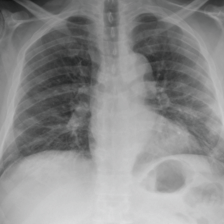


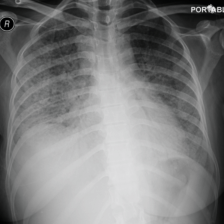


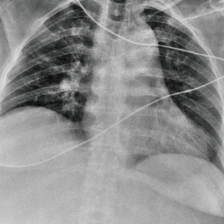


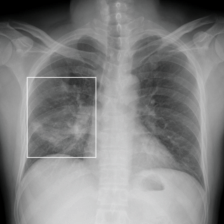

In [58]:
# Predicción sobre conjunto de datos de pruebas (test)
visualize_model(modelo_tf_resnet18, test_loader, CLASS_NAMES, num_images = 2)

In [ ]:
# df_pred_prob_test = pd.DataFrame({'ID': files_test_image, 'prob': y_pred_prob_test_pers_densenet201_2 },
#                                  columns=['ID', 'prob']
#                                  )
# df_pred_prob_test.head()

Métricas de Rendimiento (Matriz de Confusión y AUC)


Matriz de Confusión:

[[103   6]
 [  3  73]] 


Matriz de Confusión sin Normalizar


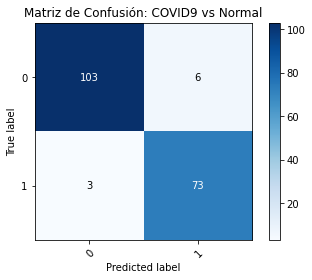


Métricas:

Exactitud (Accuracy): 95.14%
Sensitividad: 96.05%
Especificidad: 94.50%
Prevalencia: 41.08%


Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       109
           1       0.92      0.96      0.94        76

    accuracy                           0.95       185
   macro avg       0.95      0.95      0.95       185
weighted avg       0.95      0.95      0.95       185



In [68]:
cm = confusion_matrix(test_targets_rn18, test_preds_rn18)
print("\nMatriz de Confusión:\n")
print(cm, '\n\n')

plot_confusion_matrix(test_targets_rn18, test_preds_rn18, normalize=False, title="Matriz de Confusión: COVID9 vs Normal")

# Métricas (https://en.wikipedia.org/wiki/Confusion_matrix)
TN, FP, FN, TP = cm.ravel()

exactitud = (TP + TN)/(TP + TN + FN + FP)
sensitividad = TP / (TP + FN)
especificidad = TN / (TN + FP)
prevalencia = np.sum(test_targets_rn18)/len(test_targets_rn18)

print("\nMétricas:\n")
print("Exactitud (Accuracy): {:.2%}".format(exactitud))
print("Sensitividad: {:.2%}".format(sensitividad))
print("Especificidad: {:.2%}".format(especificidad))
print("Prevalencia: {:.2%}".format(prevalencia))


print("\n\nReporte de clasificacion:",)
print(classification_report(test_targets_rn18, test_preds_rn18))

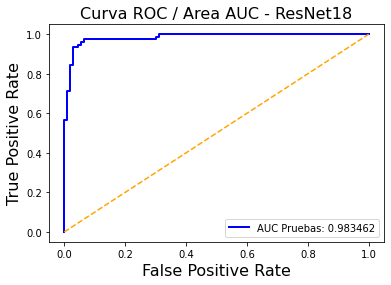


Test AUC = 0.9834620956059874


In [77]:
#---------------------------------------------
# AUC
#---------------------------------------------
# ROC Curve
fpr, tpr, thr = roc_curve(test_targets_rn18, test_probs_rn18)
roc_auc_tf_rn18 = auc(fpr, tpr)

label_test = 'AUC Pruebas:' + ' {0:.6f}'.format(roc_auc_tf_rn18)
plt.plot(fpr, tpr, c = 'b', label = label_test, linewidth = 2)
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Curva ROC / Area AUC - ResNet18', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 10)
plt.show()

# AUC Score
print('\nTest AUC =', roc_auc_tf_rn18)
#AUC = roc_auc_score(test_targets_rn18, test_probs_rn18)
#print("AUC: {:.2%}".format(AUC), '\n\n')

<a id="section23"></a>
## <font color="#004D7F"> 4.3. Transfer Learning con DenseNet</font>

In [64]:
# Definimos el modelo
modelo_tf_densenet121 = models.densenet121(pretrained = True) 
print(modelo_tf_densenet121)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [70]:
# "Congelar" los pesos del modelo pre-entrenado
for param in modelo_tf_densenet121.parameters():
  param.requires_grad = False

# Modificamos la última capa para clasificación binaria (del problema)
modelo_tf_densenet121.classifier = nn.Linear(in_features=1024, out_features=NUM_CLASSES)
modelo_tf_densenet121 = modelo_tf_densenet121.to(device)

In [71]:
# Creacion de optimizador SGD
optimizer_tf_densenet121 = torch.optim.SGD(modelo_tf_densenet121.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Creacion de Scheduler
scheduler_tf_densenet121 = torch.optim.lr_scheduler.StepLR(optimizer_tf_densenet121, step_size=7, gamma=0.1)

In [72]:
# Creacion de instancia de Funcion de Perdida Cross Entropy
criterion_tf_densenet121 = nn.CrossEntropyLoss()

In [73]:
# Entrenamiento del modelo
modelo_tf_densenet121, result_densenet21, list_epochs_densenet21, train_losses_densenet21, train_accs_densenet21, valid_losses_densenet21, valid_accs_densenet21 = train_model(device,
                                                                                                                                                                               modelo_tf_densenet121, 
                                                                                                                                                                               train_loader,
                                                                                                                                                                               valid_loader,
                                                                                                                                                                               criterion_tf_densenet121, 
                                                                                                                                                                               optimizer_tf_densenet121, 
                                                                                                                                                                               scheduler_tf_densenet121, 
                                                                                                                                                                               num_epochs=NUM_EPOCHS)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.7690      0.5968      0.8951      0.6022    ***    
    1      0.8336      0.6201      0.7620      0.5699           
    2      0.6797      0.6738      0.6524      0.6290    ***    
    3      0.7304      0.6577      0.7338      0.6452    ***    
    4      0.6242      0.7151      0.6889      0.6667    ***    
    5      0.6582      0.6882      1.3493      0.5161           
    6      0.7727      0.6541      1.0690      0.5215           
    7      0.5087      0.7599      0.8318      0.6237           
    8      0.4837      0.7670      0.7010      0.6613           
    9      0.5123      0.7706      0.7321      0.6344           
   10      0.4991      0.7634      0.7767      0.6344           
   11      0.5137      0.7437      0.8064      0.6022           
   12      0.4871      0.7760      0.6652      0.6559           
   13      0.4688      0.78

In [74]:
result_densenet21

{'train_acc': array(0.78853047),
 'train_loss': 0.4578056887166047,
 'val_acc': array(0.64516129),
 'val_loss': 0.6768960027444747}

In [75]:
# Loss vs Epochs
fig = go.Figure()

fig.add_trace(go.Scatter(x=list_epochs_densenet21, y=train_losses_densenet21, mode='lines', name='train loss', line=dict(color='rgb(0, 0, 255)')))
fig.add_trace(go.Scatter(x=list_epochs_densenet21, y=valid_losses_densenet21, mode='lines', name='valid loss', line=dict(color='rgb(255, 127, 0)')))

fig.update_layout(xaxis_title='Epochs',yaxis_title='Loss', title="Curva de Función de Pérdida")
fig.show()

In [76]:
# Accuracy vs Epochs
fig = go.Figure()

fig.add_trace(go.Scatter(x=list_epochs_densenet21, y=train_accs_densenet21, mode='lines', name='train acc', line=dict(color='rgb(0, 0, 255)')))
fig.add_trace(go.Scatter(x=list_epochs_densenet21, y=valid_accs_densenet21, mode='lines', name='valid acc', line=dict(color='rgb(255, 127, 0)')))

fig.update_layout(xaxis_title='Epochs',yaxis_title='Accuracy', title="Curva de Métrica de Clasificación")
fig.show()

In [77]:
!pwd

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos


In [ ]:
# Cambiar el directorio actual al directorio de modelos del proyecto
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos/"

In [78]:
#..............................
# Exportar Datos
#..............................
# Guardar el modelo en un directorio de modelos del proyecto
torch.save(modelo_tf_densenet121.state_dict(), 'modelo_tf_densenet121.pth')
torch.save(optimizer_tf_densenet121.state_dict(), 'optimizer_tf_densenet121.pth')

In [79]:
# Cambiar a direccion raiz del proyecto
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/"

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA


In [80]:
# Cambiar el directorio actual al directorio de modelos del proyecto
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos/"

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos


In [83]:
!pwd

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos


In [ ]:
#..............................
# Importar Datos
#..............................
# Nota:
# Importar desde el directorio de modelos del proyecto

modelo_tf_densenet121 = models.densenet121(pretrained=True)

# "Congelar" los pesos del modelo pre-entrenado
for param in modelo_tf_densenet121.parameters():
  param.requires_grad = False

# Modificamos la última capa para clasificación binaria (del problema)
modelo_tf_densenet121.classifier = nn.Linear(in_features=1024, out_features=NUM_CLASSES)

modelo_tf_densenet121 = modelo_tf_densenet121.to(device)

network_state_dict = torch.load('modelo_tf_densenet121.pth')
#network_state_dict = torch.load('modelo_tf_densenet121.pth', map_location=torch.device('cpu'))
modelo_tf_densenet121.load_state_dict(network_state_dict, strict=False)


optimizer_tf_densenet121 = optim.SGD(modelo_tf_densenet121.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer_state_dict = torch.load('optimizer_tf_densenet121.pth')
#optimizer_state_dict = torch.load('optimizer_tf_densenet121.pth', map_location=torch.device('cpu'))
optimizer_tf_densenet121.load_state_dict(optimizer_state_dict)

# Creacion de instancia de Funcion de Perdida Cross Entropy
criterion_tf_densenet121 = nn.CrossEntropyLoss()

Predicción

In [96]:
test_probs_densenet121_00, test_preds_densenet121_00, test_targets_densenet121_00 = test(device, 
                                                                                         modelo_tf_densenet121, 
                                                                                         test_loader, 
                                                                                         criterion_tf_densenet121
                                                                                         )

BatchId    Cant. Imagenes
------------------------------------------------------------------
1           10
2           10
3           10
4           10
5           10
6           10
7           10
8           10
9           10
10           10
11           10
12           10
13           10
14           10
15           10
16           10
17           10
18           10
19           5
------------------------------------------------------------------
Prediction complete in 0m 10s

Test Avg. Loss: 0.6905
Test Accuracy: 0.6811


In [97]:
test_probs_densenet121, test_probs_densenet121_01, test_preds_densenet121, test_targets_densenet121 = [],[],[],[]

for i in test_probs_densenet121_00:
  for j in range(len(i)):
    test_probs_densenet121_01.append(i.cpu().numpy()[j])   

for arr in test_probs_densenet121_01:
  #print(arr, ' | ', arr[1])
  test_probs_densenet121.append(arr[1])

for i in test_preds_densenet121_00:
  for j in range(len(i)):
    test_preds_densenet121.append(i.cpu().detach().numpy()[j])

for i in test_targets_densenet121_00:
  for j in range(len(i)):
    test_targets_densenet121.append(i.cpu().numpy()[j]) 

In [98]:
i = 10

print(test_probs_densenet121_01[i])
print(test_probs_densenet121[i])
print(test_preds_densenet121[i])
print(test_targets_densenet121[i])

[0.7280217  0.27197835]
0.27197835
0
1



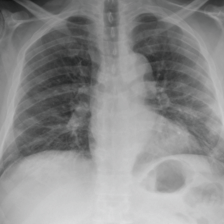


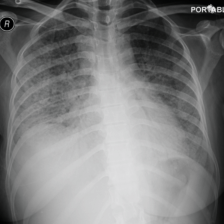

In [99]:
# Predicción sobre conjunto de datos de pruebas (test)
visualize_model(modelo_tf_densenet121, test_loader, CLASS_NAMES, num_images = 2)

In [ ]:
# df_pred_prob_test = pd.DataFrame({'ID': files_test_image, 'prob': y_pred_prob_test_pers_densenet121 },
#                                  columns=['ID', 'prob']
#                                  )
# df_pred_prob_test.head()

Métricas de Rendimiento (Matriz de Confusión y AUC)


Matriz de Confusión:

[[76 34]
 [25 50]] 


Matriz de Confusión sin Normalizar


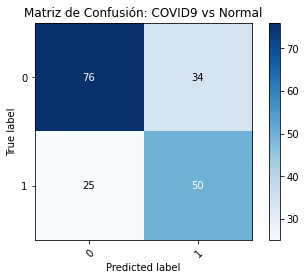


Métricas:

Exactitud (Accuracy): 68.11%
Sensitividad: 66.67%
Especificidad: 69.09%
Prevalencia: 40.54%


Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       110
           1       0.60      0.67      0.63        75

    accuracy                           0.68       185
   macro avg       0.67      0.68      0.67       185
weighted avg       0.69      0.68      0.68       185



In [100]:
cm = confusion_matrix(test_targets_densenet121, test_preds_densenet121)
print("\nMatriz de Confusión:\n")
print(cm, '\n\n')

plot_confusion_matrix(test_targets_densenet121, test_preds_densenet121, normalize=False, title="Matriz de Confusión: COVID9 vs Normal")

# Métricas (https://en.wikipedia.org/wiki/Confusion_matrix)
TN, FP, FN, TP = cm.ravel()

exactitud = (TP + TN)/(TP + TN + FN + FP)
sensitividad = TP / (TP + FN)
especificidad = TN / (TN + FP)
prevalencia = np.sum(test_targets_densenet121)/len(test_targets_densenet121)

print("\nMétricas:\n")
print("Exactitud (Accuracy): {:.2%}".format(exactitud))
print("Sensitividad: {:.2%}".format(sensitividad))
print("Especificidad: {:.2%}".format(especificidad))
print("Prevalencia: {:.2%}".format(prevalencia))


print("\n\nReporte de clasificacion:",)
print(classification_report(test_targets_densenet121, test_preds_densenet121))

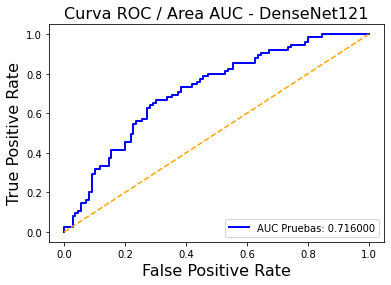


Test AUC = 0.716


In [101]:
#---------------------------------------------
# AUC
#---------------------------------------------
# ROC Curve
fpr, tpr, thr = roc_curve(test_targets_densenet121, test_probs_densenet121)
roc_auc_tf_densenet121 = auc(fpr, tpr)

label_test = 'AUC Pruebas:' + ' {0:.6f}'.format(roc_auc_tf_densenet121)
plt.plot(fpr, tpr, c = 'b', label = label_test, linewidth = 2)
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Curva ROC / Area AUC - DenseNet121', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 10)
plt.show()

# AUC Score
print('\nTest AUC =', roc_auc_tf_densenet121)
#AUC = roc_auc_score(test_targets_densenet121, test_probs_densenet121)
#print("AUC: {:.2%}".format(AUC), '\n\n')

<a id="section23"></a>
## <font color="#004D7F"> 4.4. Transfer Learning con VGG11</font>

In [113]:
# Definimos el modelo
modelo_tf_vgg11 = models.vgg11_bn(pretrained = True) 
print(modelo_tf_vgg11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [114]:
# "Congelar" los pesos del modelo pre-entrenado
for param in modelo_tf_vgg11.parameters():
  param.requires_grad = False

# Modificamos la última capa para clasificación binaria (del problema)
modelo_tf_vgg11.classifier[6] = nn.Linear(in_features=4096, out_features=NUM_CLASSES)
modelo_tf_vgg11 = modelo_tf_vgg11.to(device)

In [115]:
# Creacion de optimizador SGD
optimizer_tf_vgg11 = torch.optim.SGD(modelo_tf_vgg11.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Creacion de Scheduler
scheduler_tf_vgg11 = torch.optim.lr_scheduler.StepLR(optimizer_tf_vgg11, step_size=7, gamma=0.1)

In [116]:
# Creacion de instancia de Funcion de Perdida Cross Entropy
criterion_tf_vgg11 = nn.CrossEntropyLoss()

In [117]:
# Entrenamiento del modelo
modelo_tf_vgg11, result_vgg11, list_epochs_vgg11, train_losses_vgg11, train_accs_vgg11, valid_losses_vgg11, valid_accs_vgg11 = train_model(device,
                                                                                                                                           modelo_tf_vgg11, 
                                                                                                                                           train_loader,
                                                                                                                                           valid_loader,
                                                                                                                                           criterion_tf_vgg11, 
                                                                                                                                           optimizer_tf_vgg11, 
                                                                                                                                           scheduler_tf_vgg11, 
                                                                                                                                           num_epochs=NUM_EPOCHS)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.7761      0.6219      0.6495      0.6559    ***    
    1      0.6815      0.6971      0.6253      0.6720    ***    
    2      0.6560      0.6989      0.6357      0.7151    ***    
    3      0.7346      0.6792      0.7188      0.6452           
    4      0.6857      0.7151      0.7821      0.6828           
    5      0.6105      0.7186      0.6573      0.6452           
    6      0.6572      0.7294      0.6727      0.7043           
    7      0.5711      0.7473      0.6632      0.7043           
    8      0.5447      0.7527      0.7155      0.6828           
    9      0.5600      0.7509      0.6781      0.6720           
   10      0.5869      0.7563      0.6731      0.6559           
   11      0.5678      0.7563      0.6745      0.6882           
   12      0.5560      0.7419      0.6687      0.6828           
   13      0.5217      0.74

In [118]:
modelo_tf_vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [119]:
# Loss vs Epochs
fig = go.Figure()

fig.add_trace(go.Scatter(x=list_epochs_vgg11, y=train_losses_vgg11, mode='lines', name='train loss', line=dict(color='rgb(0, 0, 255)')))
fig.add_trace(go.Scatter(x=list_epochs_vgg11, y=valid_losses_vgg11, mode='lines', name='valid loss', line=dict(color='rgb(255, 127, 0)')))

fig.update_layout(xaxis_title='Epochs',yaxis_title='Loss', title="Curva de Función de Pérdida")
fig.show()

In [120]:
# Accuracy vs Epochs
fig = go.Figure()

fig.add_trace(go.Scatter(x=list_epochs_vgg11, y=train_accs_vgg11, mode='lines', name='train acc', line=dict(color='rgb(0, 0, 255)')))
fig.add_trace(go.Scatter(x=list_epochs_vgg11, y=valid_accs_vgg11, mode='lines', name='valid acc', line=dict(color='rgb(255, 127, 0)')))

fig.update_layout(xaxis_title='Epochs',yaxis_title='Accuracy', title="Curva de Métrica de Clasificación")
fig.show()

In [121]:
!pwd

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos


In [ ]:
# Cambiar el directorio actual al directorio de modelos del proyecto
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos/"

In [122]:
#..............................
# Exportar Datos
#..............................
# Guardar el modelo en un directorio de modelos del proyecto
torch.save(modelo_tf_vgg11.state_dict(), 'modelo_tf_vgg11.pth')
torch.save(modelo_tf_vgg11.state_dict(), 'optimizer_tf_vgg11.pth')

In [ ]:
# Cambiar a direccion raiz del proyecto
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/"

In [ ]:
# Cambiar el directorio actual al directorio de modelos del proyecto
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos/"

In [130]:
!pwd

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/modelos


In [ ]:
#..............................
# Importar Datos
#..............................
# Nota:
# Importar desde el directorio de modelos del proyecto

modelo_tf_vgg11 = models.vgg11_bn(pretrained=True)

# "Congelar" los pesos del modelo pre-entrenado
for param in modelo_tf_vgg11.parameters():
  param.requires_grad = False

# Modificamos la última capa para clasificación binaria (del problema)
modelo_tf_vgg11.classifier[6] = nn.Linear(in_features=4096, out_features=NUM_CLASSES)

modelo_tf_vgg11 = modelo_tf_vgg11.to(device)

network_state_dict = torch.load('modelo_tf_vgg11.pth')
#network_state_dict = torch.load('modelo_tf_vgg11.pth', map_location=torch.device('cpu'))
modelo_tf_vgg11.load_state_dict(network_state_dict)

optimizer_tf_vgg11 = torch.optim.SGD(modelo_tf_vgg11.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer_state_dict = torch.load('optimizer_tf_vgg11.pth')
#optimizer_state_dict = torch.load('optimizer_tf_vgg11.pth', map_location=torch.device('cpu'))
optimizer_tf_vgg11.load_state_dict(optimizer_state_dict)

# Creacion de instancia de Funcion de Perdida Cross Entropy
criterion_tf_vgg11 = nn.CrossEntropyLoss()

Predicción

In [123]:
test_probs_vgg11_00, test_preds_vgg11_00, test_targets_vgg11_00 = test(device, 
                                                                       modelo_tf_vgg11, 
                                                                       test_loader, 
                                                                       criterion_tf_vgg11
                                                                       )

BatchId    Cant. Imagenes
------------------------------------------------------------------
1           10
2           10
3           10
4           10
5           10
6           10
7           10
8           10
9           10
10           10
11           10
12           10
13           10
14           10
15           10
16           10
17           10
18           10
19           5
------------------------------------------------------------------
Prediction complete in 0m 9s

Test Avg. Loss: 0.6327
Test Accuracy: 0.7243


In [124]:
test_probs_vgg11, test_probs_vgg11_01, test_preds_vgg11, test_targets_vgg11 = [],[],[],[]

for i in test_probs_vgg11_00:
  for j in range(len(i)):
    test_probs_vgg11_01.append(i.cpu().numpy()[j])   

for arr in test_probs_vgg11_01:
  #print(arr, ' | ', arr[1])
  test_probs_vgg11.append(arr[1])

for i in test_preds_vgg11_00:
  for j in range(len(i)):
    test_preds_vgg11.append(i.cpu().detach().numpy()[j])

for i in test_targets_vgg11_00:
  for j in range(len(i)):
    test_targets_vgg11.append(i.cpu().numpy()[j]) 

In [125]:
i = 10

print(test_probs_vgg11_01[i])
print(test_probs_vgg11[i])
print(test_preds_vgg11[i])
print(test_targets_vgg11[i])

[0.4147355 0.5852645]
0.5852645
1
1



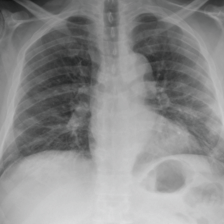


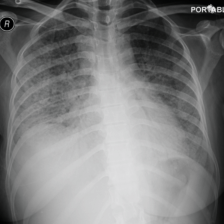

In [126]:
# Predicción sobre conjunto de datos de pruebas (test)
visualize_model(modelo_tf_vgg11, test_loader, CLASS_NAMES, num_images = 2)

In [ ]:
# df_pred_prob_test = pd.DataFrame({'ID': files_test_image, 'prob': y_pred_prob_test_pers_vgg11 },
#                                  columns=['ID', 'prob']
#                                  )
# df_pred_prob_test.head()

Métricas de Rendimiento (Matriz de Confusión y AUC)


Matriz de Confusión:

[[96 14]
 [37 38]] 


Matriz de Confusión sin Normalizar


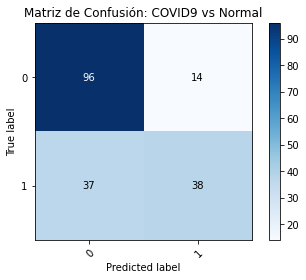


Métricas:

Exactitud (Accuracy): 72.43%
Sensitividad: 50.67%
Especificidad: 87.27%
Prevalencia: 40.54%


Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       110
           1       0.73      0.51      0.60        75

    accuracy                           0.72       185
   macro avg       0.73      0.69      0.69       185
weighted avg       0.73      0.72      0.71       185



In [127]:
cm = confusion_matrix(test_targets_vgg11, test_preds_vgg11)
print("\nMatriz de Confusión:\n")
print(cm, '\n\n')

plot_confusion_matrix(test_targets_vgg11, test_preds_vgg11, normalize=False, title="Matriz de Confusión: COVID9 vs Normal")

# Métricas (https://en.wikipedia.org/wiki/Confusion_matrix)
TN, FP, FN, TP = cm.ravel()

exactitud = (TP + TN)/(TP + TN + FN + FP)
sensitividad = TP / (TP + FN)
especificidad = TN / (TN + FP)
prevalencia = np.sum(test_targets_vgg11)/len(test_targets_vgg11)

print("\nMétricas:\n")
print("Exactitud (Accuracy): {:.2%}".format(exactitud))
print("Sensitividad: {:.2%}".format(sensitividad))
print("Especificidad: {:.2%}".format(especificidad))
print("Prevalencia: {:.2%}".format(prevalencia))


print("\n\nReporte de clasificacion:",)
print(classification_report(test_targets_vgg11, test_preds_vgg11))

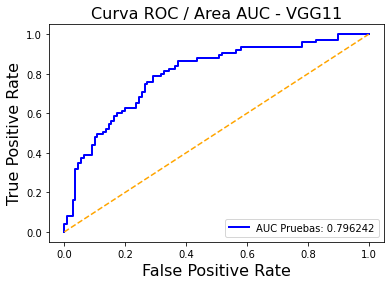


Test AUC = 0.7962424242424243


In [128]:
#---------------------------------------------
# AUC
#---------------------------------------------
# ROC Curve
fpr, tpr, thr = roc_curve(test_targets_vgg11, test_probs_vgg11)
roc_auc_tf_vgg11 = auc(fpr, tpr)

label_test = 'AUC Pruebas:' + ' {0:.6f}'.format(roc_auc_tf_vgg11)
plt.plot(fpr, tpr, c = 'b', label = label_test, linewidth = 2)
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Curva ROC / Area AUC - VGG11', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 10)
plt.show()

# AUC Score
print('\nTest AUC =', roc_auc_tf_vgg11)
#AUC = roc_auc_score(test_targets_vgg11, test_probs_vgg11)
#print("AUC: {:.2%}".format(AUC), '\n\n')

<a id="section0"></a>
# <font color="#004D7F" size=6>5. EVALUACIÓN</font>